#Introduction

In this project, I train **Convolutional Neural Networks (CNNs)** for object classification using the **CIFAR-10 dataset**, experimenting with various architectures to optimize accuracy. After selecting the best-performing model, I evaluate its performance on custom images, assessing its real-world generalization.

#Resources and Inspiration

This computer vision project is inspired by and a result of my **self-study** of courses by [Justin Johnson](https://web.eecs.umich.edu/~justincj/):

1️⃣ Recorded lectures from [EECS 498.008 / 598.008 Deep Learning for Computer Vision (University of Michigan, 2019)](https://web.eecs.umich.edu/~justincj/teaching/eecs498/WI2022/) – available [here](https://youtube.com/playlist?list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r&si=7anD8Rvx9kpoVaz2)

2️⃣ Assignment materials from [CS231n: Convolutional Neural Networks for Visual Recognition (Stanford University, 2024)](https://cs231n.github.io/)


I used ChatGPT as a code co-pilot to assist with architecture design, optimization strategies, and debugging throughout the model development process.

# Set up

Connect Google Drive to the Colab:

In [2]:
# Connect Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Define dataset folder in Google Drive
FOLDERNAME = 'CVProject/'
DATASET_PATH = f'/content/drive/My Drive/{FOLDERNAME}/Datasets/'

# Ensure dataset folder exists
import os
os.makedirs(DATASET_PATH, exist_ok=True)

# Change working directory to dataset path
%cd "$DATASET_PATH"

Mounted at /content/drive
/content/drive/My Drive/CVProject/Datasets


 Import necessary libraries and set up GPU:

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchsummary import summary

import torchvision.datasets as dset
import torchvision.transforms as T

import time

import numpy as np
import matplotlib.pyplot as plt

USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


# Part 1. Data Preparation

In my project, I use **CIFAR-10**, a well-known computer vision dataset for object recognition. It contains **60,000 32×32 color images** across **10 object classes**, with 6,000 images per class. The dataset was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton and introduced in [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) (Krizhevsky, 2009).

Let's see examples of these images below.

Files already downloaded and verified
✅ CIFAR-10 dataset downloaded to: /content/drive/My Drive/CVProject//Datasets/


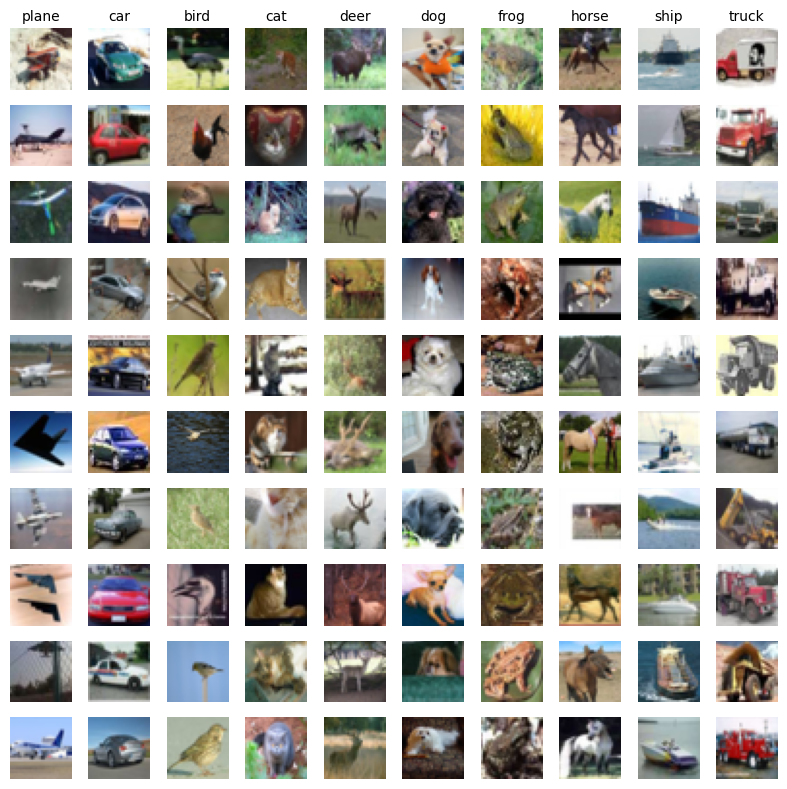

In [4]:
# Load raw CIFAR-10 dataset (without transformations for visualization)
cifar10_raw = dset.CIFAR10(root=DATASET_PATH, train=True, download=True)

print("✅ CIFAR-10 dataset downloaded to:", DATASET_PATH)

# Extract images and labels
X, y = zip(*[(np.array(cifar10_raw[i][0]), cifar10_raw[i][1]) for i in range(len(cifar10_raw))])
X = np.array(X)  # Convert to NumPy array
y = np.array(y)  # Convert labels to NumPy array

# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10

# Create 10x10 figure (10 rows, 10 columns)
fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(8, 8))

for col, cls in enumerate(classes):
    idxs = np.flatnonzero(y == col)
    selected_idxs = np.random.choice(idxs, samples_per_class, replace=False)

    for row, idx in enumerate(selected_idxs):
        axes[row, col].imshow(X[idx].astype('uint8'))
        axes[row, col].axis('off')

    axes[0, col].set_title(cls, fontsize=10)

plt.tight_layout()
plt.show()


Here, we preprocess the **CIFAR-10 dataset** by applying normalization, where we subtract the mean RGB values and divide by the standard deviation to standardize the input data.

We then split the dataset into training (49,000 samples), validation (1,000 samples), and test sets (10,000 samples), ensuring proper data handling for model evaluation.

In [5]:
# Number of training samples
NUM_TRAIN = 49000

# Define transformations (Normalization for Training)
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# Load CIFAR-10 dataset with transformations
cifar10_train = dset.CIFAR10(DATASET_PATH, train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(DATASET_PATH, train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(DATASET_PATH, train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Part 2. Train custom CNNs

I experiment with **custom CNN architectures** on **CIFAR-10**, aiming to design small yet efficient models that can be trained within **50 epochs** using **early stopping**. After training, I will select **the best-performing model** based on accuracy.

For this experiment, I use Google Colab Pro with an A100 GPU.

### Inspiration: VGG Architecture

My models are inspired by **VGG** models (VGG16 and VGG19), introduced by **Simonyan** and **Zisserman** in
"*Very Deep Convolutional Networks for Large-Scale Image Recognition*" (ICLR 2015). They first sugessted design key rules for CNNs:

* All convolutional layers use 3×3 filters, stride 1, padding 1.
* All max-pooling layers use 2×2 filters, stride 2.
* After each pooling layer, the number of channels doubles.

I follow the **VGG structure** but reduce the number of trainable layers while incorporating Batch Normalization for improved stability and experimenting with different configurations.


## Model 1. VGG_Lite

In my model **VGG_Lite**, I follow the same structure as VGG but reduce the number of trainable layers from 19 to 8 while incorporating modern Batch Normalization for improved stability.

### Key Architecture Details:

**([[Conv → BatchNorm → ReLU] × 2 → MaxPool] × 3)
→ [Linear → ReLU → Dropout → Linear] → [Softmax (via CrossEntropyLoss)]**

- Input Shape: `32×32×3`
- Conv Layers: `6`, each with `3×3` filters, `stride=1`, `padding=1`
- Pooling: `MaxPooling 2×2, stride=2`
- Batch Normalization: Used after each Conv layer
- Fully Connected Layers: `512 → 10`
- Dropout: `0.5`
- Optimizer: `SGD + Nesterov Momentum`

Below is the implementation:

### VGG_Lite architecture

In [22]:
# Define Flatten Module
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# CNN Model
VGG_Lite = nn.Sequential(
    # First Conv Block: Conv -> ReLU -> Conv -> ReLU -> MaxPool
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Second Conv Block: Conv -> ReLU -> Conv -> ReLU -> MaxPool
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Third Conv Block: Conv -> ReLU -> Conv -> ReLU -> MaxPool
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten
    Flatten(),

    # Fully Connected Layer
    nn.Linear(4 * 4 * 256, 512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 10)  # Output layer (10 classes)
)

# Optimizer Nesterov Momentum
optimizer = optim.SGD(VGG_Lite.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [23]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG_Lite.to(device)

# Display model architecture
summary(VGG_Lite, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

### Early stopping training loop

For training my models, I use the training loop with **early stopping** to prevent overfitting. The model is optimized using **Stochastic Gradient Descent (SGD) with momentum**, which updates weights based on **gradient descent and backpropagation**.

For multi-class classification, I use **Cross-Entropy Loss**, which applies **Softmax** internally to convert logits into probability distributions before computing the loss.

After each epoch, the loop calculates **training and validation accuracy**, tracks **training time per epoch**, and records **peak GPU memory usage**. At the end of training, it computes the average time per epoch and peak GPU memory usage.

**Finally, it generates three plots:**
* Learning Curve
* Training Time per Epoch
* GPU Memory Usage per Epoch

Finally training loop reload the **best model** with the **highest validation accuracy** within the training.

In [24]:
# Store accuracy and efficiency metrics
train_acc_history = []
val_acc_history = []
train_time_per_epoch = []
gpu_memory_usage = []

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_val_acc = 0.0
epochs_no_improve = 0
best_model_path = "best_model.pth"  # File to save the best model

# Count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to check model accuracy
def check_accuracy_part(loader, model):
    """
    Computes accuracy of the model on the given dataset.
    """
    model.eval()  # Set model to evaluation mode
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)  # Get predicted class
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)

    acc = float(num_correct) / num_samples
    return acc  # Return accuracy for plotting

# Training function with early stopping and best model reloading
def train_part(model, optimizer, epochs=50):
    global best_val_acc, epochs_no_improve  # Track early stopping
    model = model.to(device)  # Move model to GPU if available

    print(f"\n🔹 Model has {count_parameters(model):,} trainable parameters.\n")

    for e in range(epochs):
        model.train()  # Set model to training mode
        num_correct = 0
        num_samples = 0

        start_time = time.time()  # Start timing

        for t, (x, y) in enumerate(loader_train):
            x = x.to(device)
            y = y.to(device, dtype=torch.long)

            # Forward pass
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy within this epoch
            _, preds = scores.max(1)
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)

            if t % print_every == 0:
                print(f'Iteration {t}, loss = {loss.item():.4f}')

        # Measure time taken for this epoch
        epoch_time = time.time() - start_time
        train_time_per_epoch.append(epoch_time)

        # Store training and validation accuracy
        train_acc = num_correct / num_samples
        val_acc = check_accuracy_part(loader_val, model)

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Track peak GPU memory usage
        if torch.cuda.is_available():
            memory_used = torch.cuda.max_memory_allocated(device=device) / 1e6  # Convert bytes to MB
            gpu_memory_usage.append(memory_used)
            torch.cuda.reset_peak_memory_stats(device=device) # Reset memory tracker

        print(f"📌 Epoch {e+1}: Train Accuracy = {100 * train_acc:.2f}%, Val Accuracy = {100 * val_acc:.2f}%")
        print(f"⏳ Time per epoch: {epoch_time:.2f} sec")
        if torch.cuda.is_available():
            print(f"📊 Peak GPU memory usage: {memory_used:.2f} MB\n")

        # **Early Stopping & Best Model Saving**
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)  # Save best model
            print("✅ Model improved, saving checkpoint.")
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"⏹ Early stopping triggered after {e+1} epochs!")
            break  # Stop training

    # **Reload the best model**
    print("\n🔄 Loading best model for evaluation...")
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    model.eval()  # Set model to evaluation mode
    print(f"🏆 Best model loaded with Validation Accuracy: {100 * best_val_acc:.2f}%")

    # Calculate and print averages
    avg_time_per_epoch = sum(train_time_per_epoch) / len(train_time_per_epoch)
    avg_memory_usage = sum(gpu_memory_usage) / len(gpu_memory_usage) if gpu_memory_usage else 0

    print("\n🚀 **Training Summary:**")
    print(f"✅ Average Training Time per Epoch: {avg_time_per_epoch:.2f} sec")
    if torch.cuda.is_available():
        print(f"✅ Average Peak GPU Memory Usage: {avg_memory_usage:.2f} MB")

    # **Plot Learning Curve**
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label="Train Accuracy")
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training Time per Epoch
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_time_per_epoch) + 1), train_time_per_epoch, label="Time per Epoch (sec)", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    plt.title("Training Time per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot GPU Memory Usage per Epoch
    if torch.cuda.is_available():
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(gpu_memory_usage) + 1), gpu_memory_usage, label="GPU Memory Usage (MB)", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Peak GPU Memory Usage per Epoch")
        plt.legend()
        plt.grid(True)
        plt.show()


### VGG_Lite training

Train the model VGG_Lite with early stopping training loop:


🔹 Model has 3,249,994 trainable parameters.

Iteration 0, loss = 2.4374
Iteration 100, loss = 1.7193
Iteration 200, loss = 1.3661
Iteration 300, loss = 1.4440
Iteration 400, loss = 1.3031
Iteration 500, loss = 1.2788
Iteration 600, loss = 1.2798
Iteration 700, loss = 1.2588
📌 Epoch 1: Train Accuracy = 51.08%, Val Accuracy = 68.40%
⏳ Time per epoch: 15.00 sec
📊 Peak GPU memory usage: 288.92 MB

✅ Model improved, saving checkpoint.
Iteration 0, loss = 0.9394
Iteration 100, loss = 1.0808
Iteration 200, loss = 1.3687
Iteration 300, loss = 1.0852
Iteration 400, loss = 1.1767
Iteration 500, loss = 0.6014
Iteration 600, loss = 0.9469
Iteration 700, loss = 0.8695
📌 Epoch 2: Train Accuracy = 66.56%, Val Accuracy = 69.00%
⏳ Time per epoch: 14.82 sec
📊 Peak GPU memory usage: 289.45 MB

✅ Model improved, saving checkpoint.
Iteration 0, loss = 0.8863
Iteration 100, loss = 0.8188
Iteration 200, loss = 1.0756
Iteration 300, loss = 0.7355
Iteration 400, loss = 1.0310
Iteration 500, loss = 0.9108
Iter

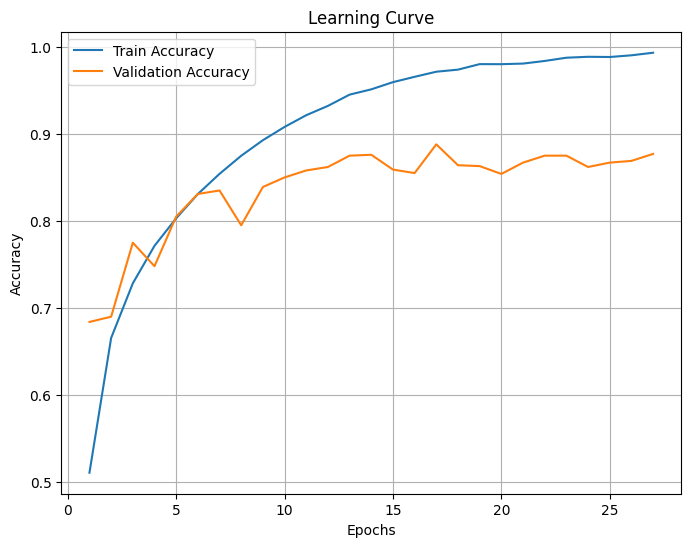

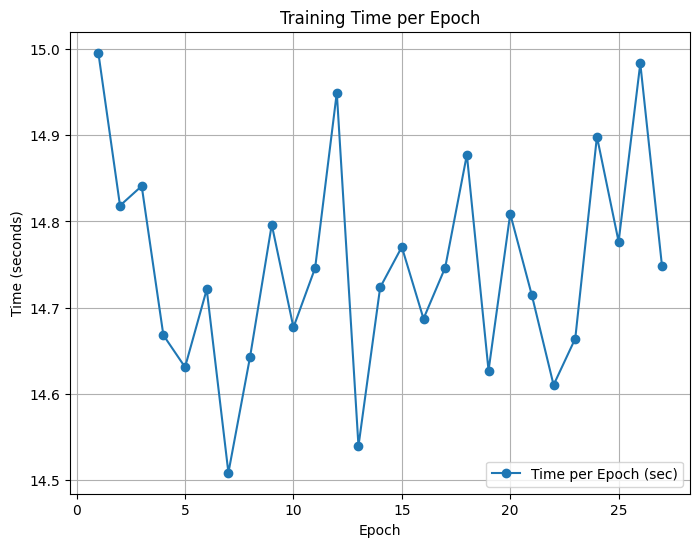

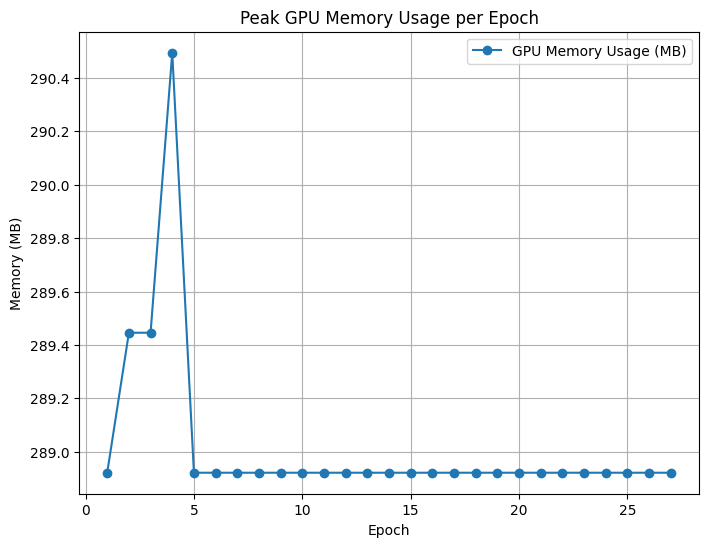

In [25]:
# Reset history
train_acc_history = []
val_acc_history = []
train_time_per_epoch = []
gpu_memory_usage = []

# Reset early stopping
patience = 10  # Number of epochs to wait for improvement
best_val_acc = 0.0
epochs_no_improve = 0

# Call training function
train_part(VGG_Lite, optimizer, epochs=50)

In [26]:
# Define the save path in Google Drive
SAVE_PATH = f"/content/drive/My Drive/{FOLDERNAME}/Models/VGG_Lite.pth"

# Save the trained model
torch.save(VGG_Lite.state_dict(), SAVE_PATH)


## Model 2. VGG_Deep

We achieved a good **88.80% validation accuracy with the VGG_Lite model**.

Now I aim to improve performance by making the model deeper. To achieve this, I have:

* Added **an extra convolutional layers per block** to capture more complex patterns.
* Introduced **an extra dense layer** in the fully connected section to improve feature representation.

I will trained new model **VGG_Deep** for 50 epochs using the same early stopping strategy to prevent overfitting and ensure fair comparison with VGG_Lite.


### Key Architecture Details:

I played with different configurations and settled on the following configuration:

**([ [Conv → BatchNorm → ReLU] × 3 → MaxPool] × 3)  → [Linear → ReLU → Dropout → Linear → ReLU → Linear] → [Softmax (via CrossEntropyLoss)]**

* Input Shape: 32×32×3
* Convolutional Layers: 9 total, each with 3×3 filters, stride=1, padding=1
* Pooling: MaxPooling 2×2, stride=2
* Batch Normalization: Used after every convolutional layer
* Fully Connected Layers: 512 → 256 → 10
* Dropout: 0.5 (to reduce overfitting)
* Optimizer: SGD + Nesterov Momentum
* Learning Rate Decay: StepLR, reducing LR by 50% every 10 epochs


### VGG_Deep architecture

In [29]:
# Define Flatten Module
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# Define VGG-Deep Model
class VGG_Deep(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_Deep, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Extra Conv Layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Extra Conv Layer
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Extra Conv Layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully Connected Layers (Added Extra Dense Layer)
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout to 0.5
            nn.Linear(512, 256),  # New dense layer
            nn.ReLU(),
            nn.Linear(256, num_classes)  # Output Layer
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc(x)
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG_Deep = VGG_Deep().to(device)

# Define the optimizer with increased weight decay
optimizer = optim.SGD(VGG_Deep.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-3)

# Implement Learning Rate Scheduler (StepLR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR by 50% every 10 epochs


In [30]:
# Display model architecture
summary(VGG_Deep, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

### VGG_Deep training

Train the model VGG_Deep with the same early stopping training loop:


🔹 Model has 4,154,250 trainable parameters.

Iteration 0, loss = 2.3115
Iteration 100, loss = 1.6802
Iteration 200, loss = 1.3750
Iteration 300, loss = 1.2945
Iteration 400, loss = 1.4347
Iteration 500, loss = 0.9494
Iteration 600, loss = 0.9917
Iteration 700, loss = 0.7148
📌 Epoch 1: Train Accuracy = 54.40%, Val Accuracy = 66.20%
⏳ Time per epoch: 16.23 sec
📊 Peak GPU memory usage: 330.36 MB

✅ Model improved, saving checkpoint.
Iteration 0, loss = 0.9403
Iteration 100, loss = 0.9466
Iteration 200, loss = 0.7370
Iteration 300, loss = 0.8957
Iteration 400, loss = 0.7053
Iteration 500, loss = 0.9425
Iteration 600, loss = 0.8364
Iteration 700, loss = 0.7239
📌 Epoch 2: Train Accuracy = 72.00%, Val Accuracy = 73.80%
⏳ Time per epoch: 16.45 sec
📊 Peak GPU memory usage: 330.36 MB

✅ Model improved, saving checkpoint.
Iteration 0, loss = 0.7082
Iteration 100, loss = 0.7543
Iteration 200, loss = 0.5216
Iteration 300, loss = 0.5233
Iteration 400, loss = 0.5570
Iteration 500, loss = 0.7231
Iter

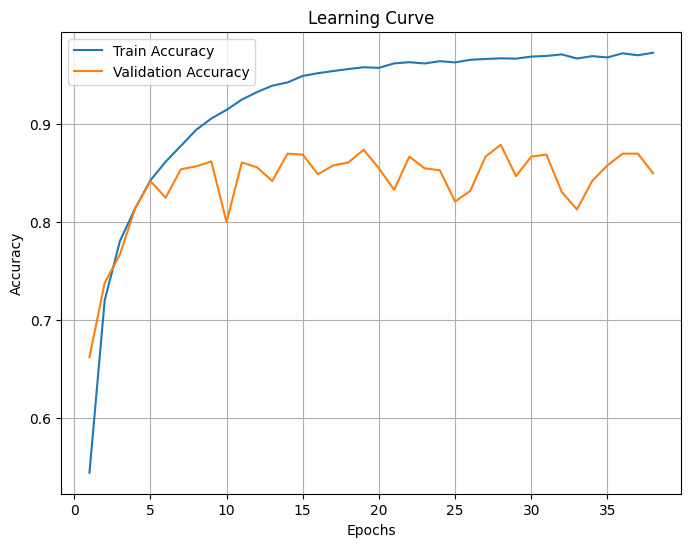

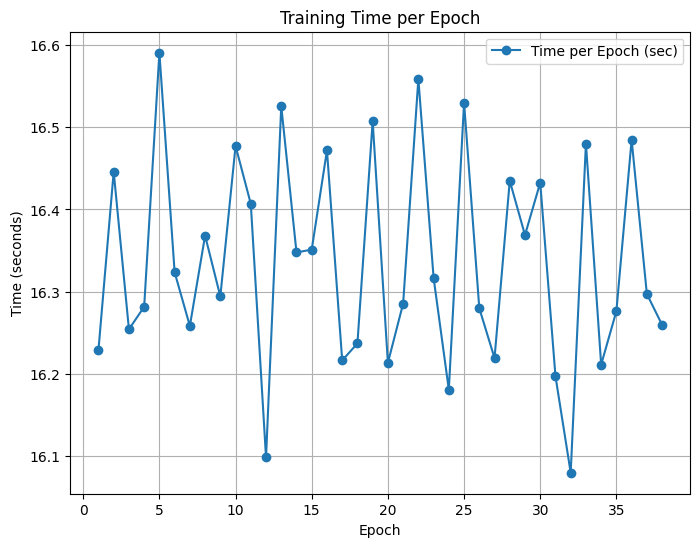

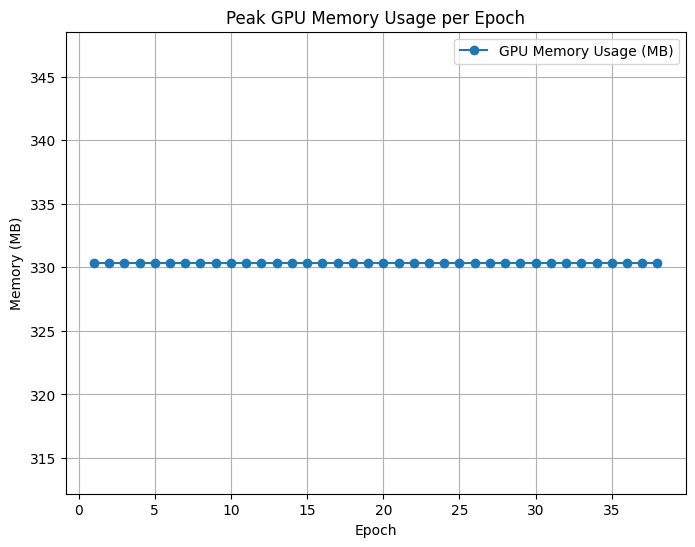

In [31]:
# Reset history
train_acc_history = []
val_acc_history = []
train_time_per_epoch = []
gpu_memory_usage = []

# Reset early stopping
patience = 10  # Number of epochs to wait for improvement
best_val_acc = 0.0
epochs_no_improve = 0

# Call training function
train_part(VGG_Deep, optimizer, epochs=50)

In [32]:
# Define the save path in Google Drive
SAVE_PATH = f"/content/drive/My Drive/{FOLDERNAME}/Models/VGG_Deep.pth"

# Save the trained model
torch.save(VGG_Deep.state_dict(), SAVE_PATH)

## Final Model Evaluation on Test Set

I received the following training results for my two models, VGG_Lite and VGG_Deep.

####**VGG_Lite training results:**

**Best model Validation Accuracy: 88.80%**

Training Summary:
* Early stopping triggered after 27 epochs
* Average Training Time per Epoch: 14.75 sec
* Average Peak GPU Memory Usage: 289.02 MB


####**VGG_Deep training results:**

**Best model Validation Accuracy: 87.90%**

Training Summary:
* Early stopping triggered after 38 epochs
* Average Training Time per Epoch: 16.34 sec
* Average Peak GPU Memory Usage: 330.36 MB


#### 🏆🏆🏆 **Based on validation accuracy the best model is VGG_Lite**

Let's do the final check on test dataset:


In [46]:
best_model = VGG_Lite
check_accuracy_part(loader_test, best_model)

0.8611

🏆🏆🏆 **The test accuracy of the best model is 86,11%**

# Conclusions

Despite its simpler architecture, **VGG_Lite** achieved **the highest accuracy** with a slight margin while also requiring fewer computational resources and less training time.

Initially, I expected the **VGG_Deep model** to perform better, but it showed signs of **overfitting** (training accuracy increased while validation accuracy remained stagnant). Additionally, it required slightly more computational power. I attempted to mitigate overfitting by adjusting configurations, such as implementing a **learning rate scheduler** and adding an **extra dense layer**, but these changes had minimal impact on the results.

**In conclusion, a simpler approach proved more effective for our CNN model implementation, given the constraints on computational resources.**

# Part 3. Evaluate final CNN accuracy on custom images

Now that I have my best custom CNN model, I'm ready to test it on my own images taken with my phone.

Let's see the results! 🚀

Evaluating: photo_2025-01-20 13.00.48.jpeg


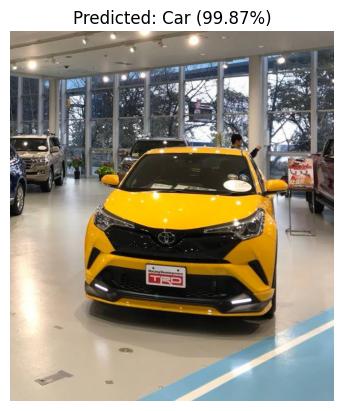

Evaluating: photo_2025-01-20 13.00.50.jpeg


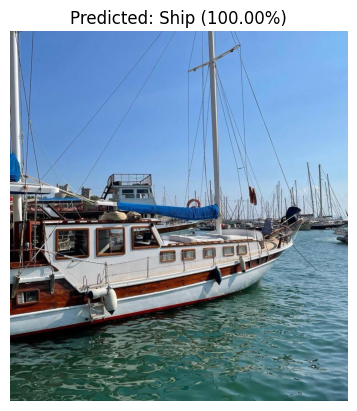

Evaluating: photo_2025-01-23 23.59.30.jpeg


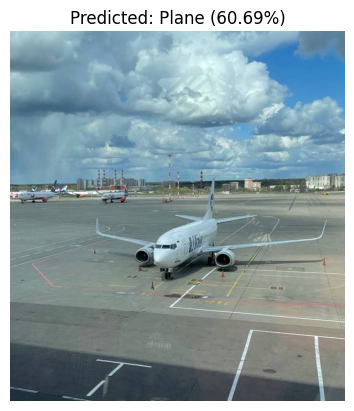

Evaluating: photo_2025-01-23 23.59.40.jpeg


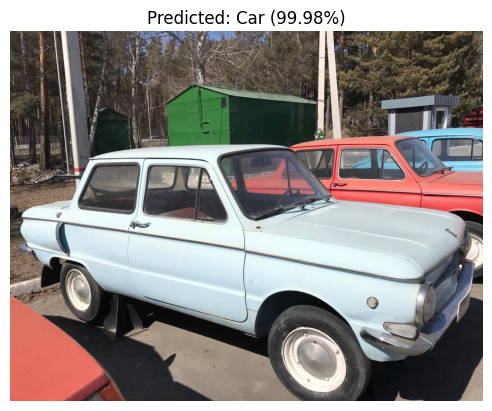

Evaluating: photo_2025-01-23 23.59.41.jpeg


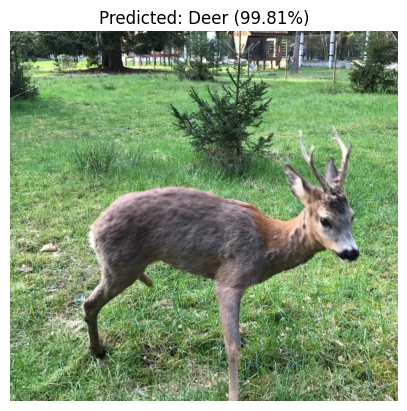

Evaluating: photo_2025-01-25 12.43.12.jpeg


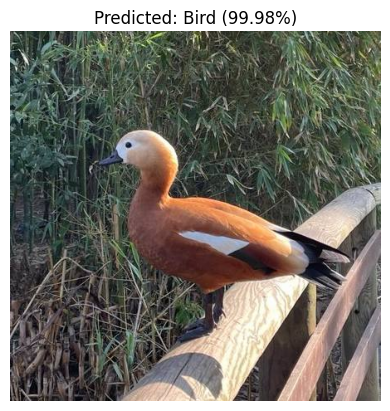

Evaluating: photo_2025-01-23 23.59.32.jpeg


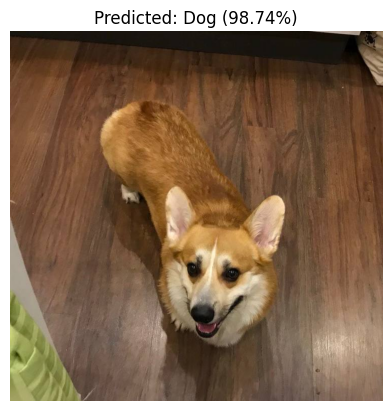

Evaluating: photo_2025-01-25 12.59.57.jpeg


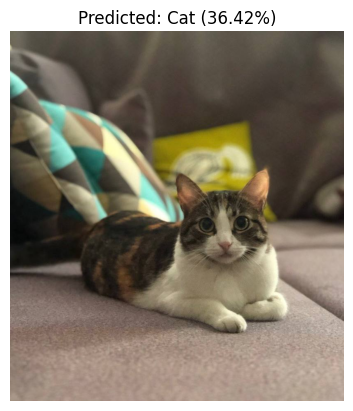

Evaluating: photo_2025-01-25 12.59.51.jpeg


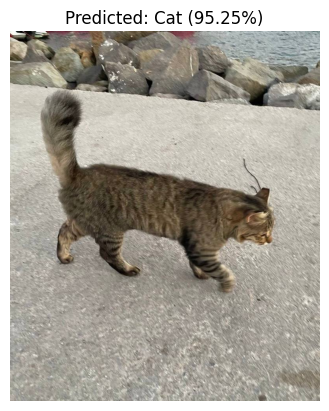

In [51]:
from PIL import Image
import os

# Define the image folder path
IMAGE_FOLDER = f"/content/drive/My Drive/{FOLDERNAME}/TestImages"

# Define image transformations (your model's settings)
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Your model's normalization
])

# Function to load and preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure 3-channel RGB
    return transform(image).unsqueeze(0)  # Add batch dimension

# Function to evaluate a single image
def evaluate_image(model, image_path, class_names):
    model.eval()  # Set model to evaluation mode
    img_tensor = preprocess_image(image_path).to(device)  # Move to GPU if available

    # Forward pass through model
    with torch.no_grad():
        scores = model(img_tensor)  # Get raw logits
        probabilities = F.softmax(scores, dim=1)  # Convert to probabilities
        predicted_class = probabilities.argmax(dim=1).item()  # Get highest probability class
        confidence = probabilities.max().item()  # Get confidence score

    # Display image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_names[predicted_class]} ({confidence * 100:.2f}%)")
    plt.show()

    return class_names[predicted_class], confidence

# Define class labels (CIFAR-10)
class_names = [
    "Plane", "Car", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Evaluate all images in the test folder
for image_file in os.listdir(IMAGE_FOLDER):
    image_path = os.path.join(IMAGE_FOLDER, image_file)
    if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        print(f"Evaluating: {image_file}")
        evaluate_image(best_model, image_path, class_names)
